# RCC Stage Prediction 24 Metabolite Panel (LC-MS+NMR)

Author: Olatomiwa Bifarin<br>
Department of Biochemistry and Molecular Biology<br>
University of Georgia<br>
Edison Lab<br>

Last edited: 04APR2021


**Goal**: To predict early and late stage RCC using urine-based metabolomics <br>

### Notebook Outline

1. [Load Data](#1)
2. [Feature Selection](#2)
3. [RCC Stage Prediction](#3)
4. [RCC Stage Potential Biomarkers: PCA, HCA, Boxplot Visualization](#4)
5. [Patient Cohort Characteristics and Confounder Analysis](#5)

In [75]:
#import python packages and libraries
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import style
import scipy
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels as sms
from statsmodels.stats import multitest
from scipy.stats import shapiro
from decimal import Decimal
from statistics import mean
#For Seaborn plots
import seaborn as sns; sns.set(style='white')

#To ignore warning
import warnings
warnings.filterwarnings('ignore')

# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'

# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk')

# Import machine learning libraries
# Test train split and K-fold validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# Random Forest
from sklearn.ensemble import RandomForestRegressor
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import preprocessing
# Scaling 
from sklearn.preprocessing import StandardScaler
# Recursive Feature Elimination
from sklearn.feature_selection import RFECV

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier

# Import Random Forest classifier, sklearn metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# test train split and K-fold validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn import decomposition

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

In [76]:
import dill
filepath = '24MetabolitePanel_Classification.pkl'
dill.load_session('workspace/24MetabolitePanel_Classification.pkl') # Load the session

## 1. Load Data (all data)
<a id="1"></a>

In [77]:
RCCdataframe = pd.read_excel('data/RCCdataframe.xlsx')

#RCCdataframe = pd.read_excel('RCCdataframe.xlsx')
# Remove samples with inconclusive staging information.
RCCdataframe = RCCdataframe[pd.notnull(RCCdataframe['Grouped Stage'])]

## 2. Machine Learning for RCC (Early vs Late) Prediction
<a id="3"></a>

_Define features and groups_

removed feature 248: Meglumine & 5408: dihydroxybutylthymine

In [78]:
final_features = {2745, 5362, 6681, 3766,
                  1372, 1904, 2122, 2317, 
                  2465, 3163, 4116, 5045, 
                  5420, 5437, 5713, 
                  5737, 5985, 6687, 6694,
                  'citrate', 'glycine', 'choline',
                  'acetone', 'pyruvate'}


In [79]:
MS_labels = pd.read_excel('data/MS_labels.xlsx')

#MS_labels = pd.read_excel('MS_labels.xlsx')

In [80]:
MS_labels[MS_labels.ID.isin(final_features)];

In [81]:
MLfeatures = RCCdataframe[list(final_features)]
MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

In [82]:
X = MLfeatures.values
X;

In [83]:
dfgrp = RCCdataframe.filter(['Grouped Stage'], axis=1)
# convert strings (RCC, Control) to integers
dfgroup = dfgrp['Grouped Stage'].map({'Early': 0, 'Late': 1}) 
# Groups
y = dfgroup.values

#### Machine Learning Model Function

In [84]:
from sklearn.metrics import confusion_matrix
from sklearn import model_selection

In [85]:
def ml_model(X, y, model, kfold=10):
    
    '''
    FUNCTION: 
    A  machine learning function under Kfold cross validation conditions  
    
    DEPENDENCY: 
    Various Sklearn packages
    from sklearn import metrics
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import KFold
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import roc_auc_score
    
    INPUTS: 
    X = numpy.ndaarray: features
    y = numpy.ndaarray: Labels encoded as 0s and 1s. 
    model = machine learning model
    kfold = numeric. K-fold default is 5. 
    
    OUTPUT: 
    A list containing the following machine learning metrics: 
    Area Under the Curve(AUC), Accuracy (ACC), Precision (PRE), 
    Recall (REC), F1-core (FS), Matthew's Correlation Coefficient (MCC). 
    
    '''

    cv = model_selection.StratifiedKFold(n_splits=kfold, random_state=42, shuffle=True)
    # define 'list' of various metrics
    AUC, ACC, PRE, REC, FS, MCC, SPE = [], [], [], [], [], [], [] 
    performance = []
    
    for (train, test), i in zip(cv.split(X, y), range(kfold)):
        # training the model
        model.fit(X[train], y[train])
        y_pred = model.predict(X[test])
        
        #Retrieving metrics after testing
        modelprobs = model.predict_proba(X[test])
        fpr, tpr, thresholds = metrics.roc_curve(y[test], modelprobs[:,1])
        roc_auc = auc(fpr, tpr)
        accuracy = metrics.accuracy_score(y[test], y_pred)
        precision = metrics.precision_score(y[test], y_pred)
        recall = metrics.recall_score(y[test], y_pred)
        f1_score = metrics.f1_score(y[test], y_pred)
        mcc = metrics.matthews_corrcoef(y[test], y_pred)
        # coding specificity
        tn, fp, fn, tp = confusion_matrix(y[test], y_pred).ravel()
        specificity = tn / (tn+fp)
        # append metrics to list
        AUC.append(roc_auc)
        ACC.append(accuracy)
        PRE.append(precision)
        REC.append(recall)
        FS.append(f1_score)
        MCC.append(mcc)
        SPE.append(specificity)
    return AUC, ACC, PRE, REC, FS, MCC, SPE

#### Machine Learning Metric Plot Function

In [86]:
def MLmetric_plot(data_dict, y_label):
    '''
    FUNCTION: 
    To plot machine learning metrics from ml_model function.   
    
    DEPENDENCY: 
    Pandas, seaborn, 
    
    INPUTS: 
    data_dict = dictionary. Contains ML model name and metric scores
    y_label = String. Label for the y-axis 
    
    OUTPUT: 
    Figure
    
    '''
    
    fig = pd.DataFrame(data=data_dict)
    splot = sns.barplot(x='Model', y=y_label, data=fig);
    #splot = sns.swarmplot(data=ACCfig, orient='h', s=10, alpha=0.7, color=".25");
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.2f'), 
                              (p.get_x() + p.get_width() / 2., p.get_height()), 
                              ha = 'center', va = 'center', xytext = (6, 15), 
                              textcoords = 'offset points')
    return splot
#plt.savefig('testACC.svg', dpi=300)



Train with various machine learning models.

## 3. ML Results

Experiment with ML algorithm for prediction.

| ML Algorithm| AUC | Accuracy | Sensitivity | Specificity|
| -- | -- | -- | -- | -- |
| ___Random Forest___ | 0.86 | 77% | 69% | 83% |
| ___k-NN___ | 0.82 | 75% | 55% | 90% |
| ___SVM-RBF___ | 0.90 | 84% | 80% | 80% |
| ___SVM-Lin___ | 0.88 | 77% | 66% | 85% |
| ___Naive Bayes___ | 0.88 | 83% | 80% | 85% |
| ___AdaBoost___ | 0.80 | 77% | 75% | 78% |
| ___Logistic Regression___ | 0.92 | 84% | 76% | 90% |

Logistic regression, SVM-RBF, Random Forest, and AdaBoost were selected for the paper.

In [87]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

#### Random Forest

NB = RandomForestClassifier(random_state=42)


metric = ml_model(X, y, NB)
NB_AUC, NB_ACC, NB_PRE, NB_REC, NB_FS, NB_MCC, NB_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

#### AdaBoost Classifier
ADA = AdaBoostClassifier(random_state=42)
metric = ml_model(X, y, ADA)
ADA_AUC, ADA_ACC, ADA_PRE, ADA_REC, ADA_FS, ADA_MCC, ADA_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

#### Logistic Regression
LR = LogisticRegression(solver="liblinear", random_state=42)
metric = ml_model(X, y, LR)
LR_AUC, LR_ACC, LR_PRE, LR_REC, LR_FS, LR_MCC, LR_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

#### SVM
#clf = svm.SVC(kernel='linear', probability=True)
clf = svm.SVC(kernel = 'rbf', probability=True, random_state=42)
metric = ml_model(X, y, clf)
clf_AUC, clf_ACC, clf_PRE, clf_REC, clf_FS, clf_MCC, clf_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

#### Voting Classifiers
vclf = VotingClassifier(
    estimators=[('nb', NB), ('ada', ADA), 
                ('lr', LR), ('clf', clf)],
    voting='soft')

metric = ml_model(X, y, vclf) 
vclf_AUC, vclf_ACC, vclf_PRE, vclf_REC, vclf_FS, vclf_MCC, vclf_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]



**AUC**

In [88]:
sns.set_context('talk', font_scale=0.8)

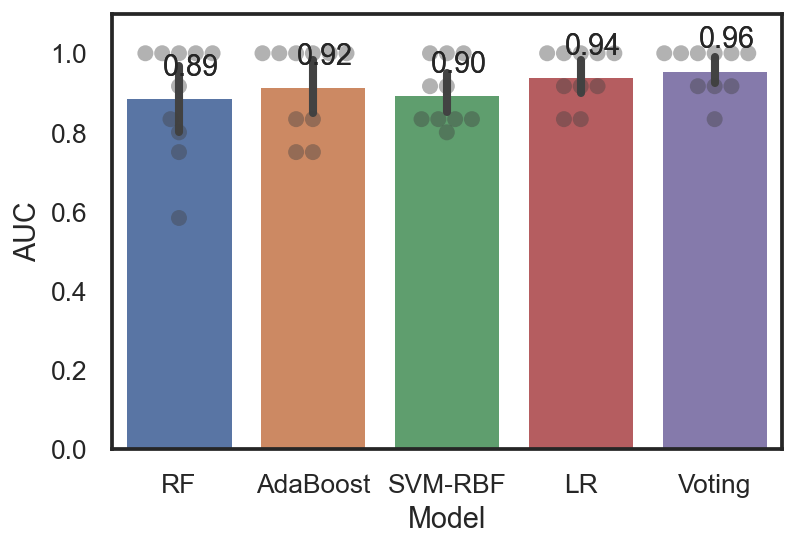

In [89]:
AUCfig = {'Model': ['RF', 'AdaBoost', 'SVM-RBF', 'LR', 'Voting'], 
               'AUC':[mean(NB_AUC), mean(ADA_AUC), mean(clf_AUC), 
                      mean(LR_AUC), mean(vclf_AUC)]}

afig = {'Naive Bayes': NB_AUC, 'AdaBoost': ADA_AUC, 
        'SVM-RBF': clf_AUC, 'LR': LR_AUC, 'Voting': vclf_AUC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

plt.savefig('24metabolite_panel_AUC.svg')
MLmetric_plot(AUCfig, 'AUC');
#plt.title('ML Model AUC Comparison for RCC prediction');

# report performance
#print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
#print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [90]:
# A function to print out all numeric (and summary of) results
def summary(name, result):
    print ('All Train result for', name, result)
    print ('Summary metric for', name, round(mean(result),2),'+/-', round(np.std(result),2))

In [91]:
summary('Random Forest', NB_AUC)
summary('Adaboost', ADA_AUC)
summary('RBF SVM', clf_AUC)
summary('Logistic Regression', LR_AUC)
summary('Voting Ensemble', vclf_AUC)

All Train result for Random Forest [0.8, 1.0, 0.75, 0.5833333333333334, 0.8333333333333333, 1.0, 0.9166666666666666, 1.0, 1.0, 1.0]
Summary metric for Random Forest 0.89 +/- 0.14
All Train result for Adaboost [1.0, 1.0, 1.0, 0.75, 0.75, 0.8333333333333334, 1.0, 1.0, 1.0, 0.8333333333333333]
Summary metric for Adaboost 0.92 +/- 0.11
All Train result for RBF SVM [0.8, 0.8333333333333333, 0.9166666666666666, 0.8333333333333334, 0.8333333333333334, 0.8333333333333333, 0.9166666666666666, 1.0, 1.0, 1.0]
Summary metric for RBF SVM 0.9 +/- 0.08
All Train result for Logistic Regression [1.0, 0.8333333333333333, 0.9166666666666666, 0.9166666666666666, 0.8333333333333333, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0]
Summary metric for Logistic Regression 0.94 +/- 0.07
All Train result for Voting Ensemble [1.0, 0.9166666666666666, 1.0, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0]
Summary metric for Voting Ensemble 0.96 +/- 0.06


**Accuracy**

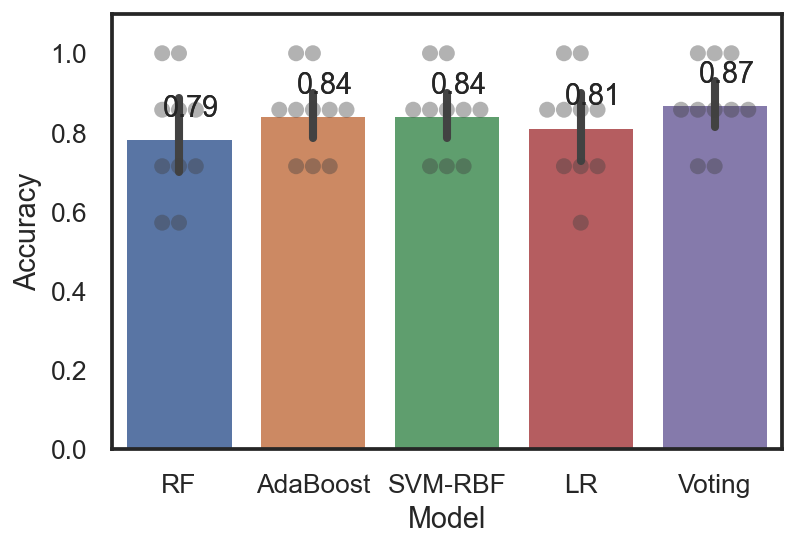

In [92]:
ACC_fig = {'Model': ['RF', 'AdaBoost', 'SVM-RBF', 'LR', 'Voting'], 
               'Accuracy':[mean(NB_ACC), mean(ADA_ACC), mean(clf_ACC), 
                           mean(LR_ACC), mean(vclf_ACC)]}

afig = {'Naive Bayes': NB_ACC, 'AdaBoost': ADA_ACC, 
        'SVM': clf_ACC, 'LR': LR_ACC, 'Voting': vclf_ACC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

plt.savefig('24metabolite_panel_ACC.svg')
MLmetric_plot(ACC_fig, 'Accuracy');

#plt.title('ML Model Accuracy Comparison for RCC prediction');

In [93]:
summary('Random Forest', NB_ACC)
summary('Adaboost', ADA_ACC)
summary('RBF SVM', clf_ACC)
summary('Logistic Regression', LR_ACC)
summary('Voting Ensemble', vclf_ACC)

All Train result for Random Forest [0.5714285714285714, 1.0, 0.7142857142857143, 0.7142857142857143, 0.5714285714285714, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 1.0, 0.8571428571428571]
Summary metric for Random Forest 0.79 +/- 0.15
All Train result for Adaboost [1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571]
Summary metric for Adaboost 0.84 +/- 0.1
All Train result for RBF SVM [0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 0.7142857142857143, 1.0, 1.0, 0.8571428571428571]
Summary metric for RBF SVM 0.84 +/- 0.1
All Train result for Logistic Regression [1.0, 0.7142857142857143, 0.8571428571428571, 0.7142857142857143, 0.5714285714285714, 0.8571428571428571, 0.8571428571428571, 1.0, 0.7142857142857143, 0.8571428571428571]
Summary metric for Logistic Regression 0.81 +/- 0.13


**Sensitivity/Recall**

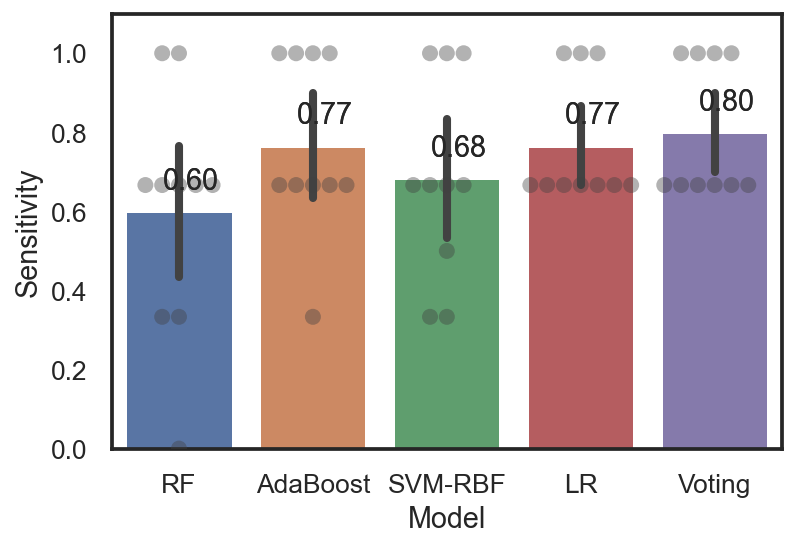

In [94]:
RECfig = {'Model': ['RF', 'AdaBoost', 'SVM-RBF', 'LR', 'Voting'], 
               'Sensitivity':[mean(NB_REC), mean(ADA_REC), mean(clf_REC), 
                              mean(LR_REC), mean(vclf_REC)]}

afig = {'Naive Bayes': NB_REC, 'AdaBoost': ADA_REC, 
        'SVM-RBF': clf_REC, 'LR': LR_REC, 'Voting': vclf_REC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

plt.savefig('24metabolite_panel_REC.svg')
MLmetric_plot(RECfig, 'Sensitivity');
#plt.title('ML Model Specificity (Recall) Comparison for RCC prediction');

In [95]:
summary('Random Forest', NB_REC)
summary('Adaboost', ADA_REC)
summary('RBF SVM', clf_REC)
summary('Logistic Regression', LR_REC)
summary('Voting Ensemble', vclf_REC)

All Train result for Random Forest [0.0, 1.0, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 1.0, 0.6666666666666666]
Summary metric for Random Forest 0.6 +/- 0.29
All Train result for Adaboost [1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 1.0, 0.6666666666666666, 0.6666666666666666, 1.0, 0.3333333333333333, 0.6666666666666666]
Summary metric for Adaboost 0.77 +/- 0.21
All Train result for RBF SVM [0.5, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 1.0, 0.6666666666666666, 0.3333333333333333, 1.0, 1.0, 0.6666666666666666]
Summary metric for RBF SVM 0.68 +/- 0.24
All Train result for Logistic Regression [1.0, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666]
Summary metric for Logistic Regression 0.77 +/- 0.15
All Train result for Voting Ensemble [1.0, 0.6666666666666666, 0.6666666666666666, 0.6666

**Specificity**

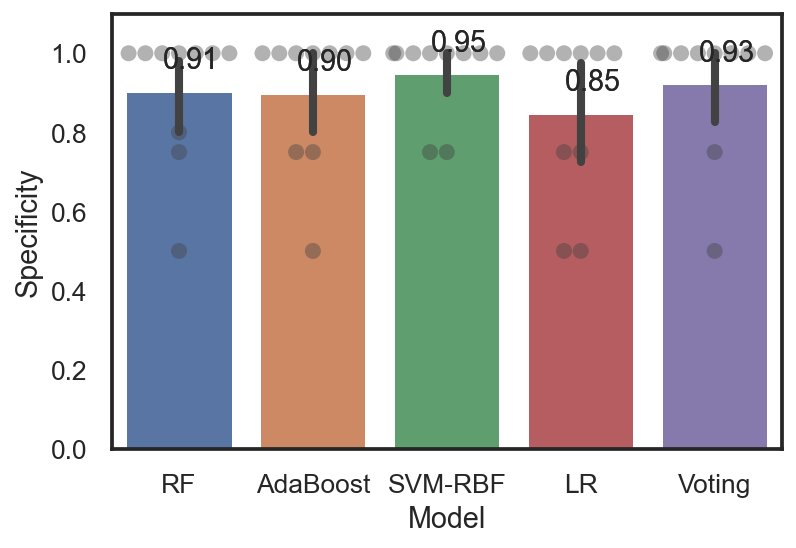

In [96]:
SPEfig = {'Model': ['RF', 'AdaBoost', 'SVM-RBF', 'LR', 'Voting'], 
               'Specificity':[mean(NB_SPE), mean(ADA_SPE), mean(clf_SPE), 
                              mean(LR_SPE), mean(vclf_SPE)]}

afig = {'Naive Bayes': NB_SPE, 'AdaBoost': ADA_SPE, 
        'SVM-RBF': clf_SPE, 'LR': LR_SPE, 'Voting': vclf_SPE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

plt.savefig('24metabolite_panel_SPE.svg')
MLmetric_plot(SPEfig, 'Specificity');
#plt.title('ML Model F1 Score Comparison for RCC prediction');

In [97]:
summary('Random Forest', NB_SPE)
summary('Adaboost', ADA_SPE)
summary('RBF SVM', clf_SPE)
summary('Logistic Regression', LR_SPE)
summary('Voting Ensemble', vclf_SPE)

All Train result for Random Forest [0.8, 1.0, 1.0, 0.75, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0]
Summary metric for Random Forest 0.9 +/- 0.16
All Train result for Adaboost [1.0, 1.0, 1.0, 1.0, 0.5, 0.75, 1.0, 0.75, 1.0, 1.0]
Summary metric for Adaboost 0.9 +/- 0.17
All Train result for RBF SVM [1.0, 1.0, 1.0, 0.75, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0]
Summary metric for RBF SVM 0.95 +/- 0.1
All Train result for Logistic Regression [1.0, 0.75, 1.0, 0.75, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0]
Summary metric for Logistic Regression 0.85 +/- 0.2
All Train result for Voting Ensemble [1.0, 1.0, 1.0, 0.75, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0]
Summary metric for Voting Ensemble 0.92 +/- 0.16


In [98]:
#import dill                            
#filepath = '24MetabolitePanel_Classification.pkl'
#dill.dump_session(filepath) # Save the session